# Python Document Search Engine

Now, we will start to put together all of the topics that we have studied so far into a series of "Python Recipes"---coding examples that illustrate the power of thinking hard about how data is organized and structured. In the first example, we will consider a "Python Search Engine" that will identify relevant items given a query string.

We're going to start with a dataset of tweets about airlines:

In [1]:
import csv

def load_data(filename):
    rtn = []
    #open the file with the csv reader
    with open(filename, newline='') as csvfile:
        tweets = csv.reader(csvfile, delimiter=',', quotechar='"') 
        next(tweets)       #skip the header   
        for row in tweets:
            rtn.append(row[10])
    return rtn

tweets = load_data('Tweets.csv')

#figure out how much data we have
size = sum([i.__sizeof__() for i in tweets]) + tweets.__sizeof__()

print('Number: ', len(tweets), '\t Size:', size/1e6,'MB','\t Bytes per tweet:', size/len(tweets))

Number:  14640 	 Size: 2.416432 MB 	 Bytes per tweet: 165.05683060109288


In [2]:
len(tweets), type(tweets)

(14640, list)

In [3]:
for tweet in tweets:
    if tweet.find("wait")>0:
        print(tweet)

@VirginAmerica awaiting my return phone call, just would prefer to use your online self-service option :(
@VirginAmerica i need to change my flight thats scheduled in 9 hours and 120 min wait time on phone. Im calling intern. Help!!
@VirginAmerica having problems Flight Booking Problems on the web site. keeps giving me an error and to contact by phone.  phone is 30 minute wait.
@VirginAmerica I rang, but there is a wait for 35 minutes!! I can book the same ticket through a vendor, fix your site
@VirginAmerica at Logan airport and waiting to checkin for my 9am flight. Checkin desk not open !!!!! Why?!
@VirginAmerica Flight from BOS &gt; LAS tomorrow was Cancelled Flightled. No notification; wait times are 1+ hour. Will you rebook on another airline?
@VirginAmerica love the 90s music blasting at gate in #Boston while waiting for flight to #SanFrancisco. Only if I could get an iced coffee!
@VirginAmerica what is your policy on flying after surgery?  I am still waiting for answer so I can 

This dataset contains a large list of tweets represented as string. We want to be able to search for phrases in these tweets. Of course, the first thing that we can do is the simple naive search routine where we scan through the entire dataset.

## Naive Search
Suppose, we wanted to find a substring in this collection of tweets, we could write the following code that iterates through each tweet and searches for a substring:

In [5]:
import datetime

def find(phrase, tweets):
    #Naive full scan approach
    start = datetime.datetime.now()
    rtn = []    
    for t in tweets:
        if phrase in t:
            rtn.append(t)
    print('Find() elapsed time: ', (datetime.datetime.now()-start).total_seconds())          
    return rtn


find('choppy landing', tweets)

find('LAX', tweets)

Find() elapsed time:  0.004384
Find() elapsed time:  0.003384


["@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 '@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix',
 '@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!',
 '@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️',
 '@VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin',
 '@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM',
 '@VirginAmerica Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃',
 '@VirginAmerica congrats, you just got all my business from EWR to SFO/LAX. Fuck you @united fl1289 SFO/EWR was the cl

In [6]:
find("Landed at JFK", tweets)

Find() elapsed time:  0.002216


[]

In [7]:
find("us a flt out", tweets)

Find() elapsed time:  0.003193


['@VirginAmerica Can you find us a flt out of LAX that is sooner than midnight on Monday? That would be great customer service 😃']

That's pretty fast (5  ms!) But imagine if you had to run a million of such lookups, that would be 5000 seconds! At scale, small overheads add up. 

Now, we use our "inverted indexing" trick to make such searches faster.

## Inverted Index
Next, we will try to do the same search with an inverted index. The indexing structure that we will use is a python dictionary.

In [9]:
import string 

def build_index(tweets):
    start = datetime.datetime.now() 
    index = {}
    
    #some code to deal with punctuation
    table = str.maketrans('', '', string.punctuation)
    for i, t in enumerate(tweets):      
        words = t.translate(table).split()       
        for w in words:         
            if w not in index:
                index[w] = set()          
            index[w].add(i) #add a pointer to the relevant tweet       
    print('build_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())      
    return index

index = build_index(tweets)

build_index() elapsed time:  0.398478


Notice that build_index is about a 100x slower than a single query. What does this mean? Basically, indexing is only valuable if you run a lot of queries! 

The next challenge is how to use an inverted index to answer general substring queries. In class, we showed how to do exact keyword lookup but the phrase 'choppy landing' is actually two words. This is actually not a problem, and we can use the inverted index to retrieve a set of candidates and then use the naive find method among just those candidates.

So, let's write a new find function that can use this index:
* It splits the phrase into its constituent words
* Searches each word in the inverted index, finds a set of possibly relevant tweets (that match on a single word)
* Then double checks that set.

In [14]:
len(index["here"])

264

In [15]:
tweets[93]

'@VirginAmerica just landed in LAX, an hour after I should of been here. Your no Late Flight bag check is not business travel friendly #nomorevirgin'

In [16]:
len(index["landed"]), len(index["Chicago"]), len(index["in"])

(73, 73, 2245)

In [26]:
len(index)

20042

In [28]:
index["choppy"], index["landing"]

({302},
 {178,
  206,
  302,
  1435,
  1765,
  2094,
  2199,
  2238,
  2277,
  2451,
  2473,
  2665,
  2698,
  2786,
  2831,
  2916,
  3157,
  3254,
  3654,
  4258,
  4342,
  4603,
  4949,
  5447,
  5490,
  5779,
  5815,
  6307,
  6347,
  6420,
  6671,
  6822,
  6876,
  7249,
  7397,
  7400,
  7531,
  7538,
  7877,
  8239,
  9336,
  9550,
  9696,
  9879,
  10317,
  10950,
  11167,
  11272,
  11314,
  11992,
  12153,
  12390,
  12967,
  13069,
  13153,
  13423,
  13440,
  13699,
  14625})

In [30]:
index["choppy"].intersection(index["landing"])

{302}

In [32]:
def find_index(phrase, tweets, index):
    start = datetime.datetime.now()
    words = phrase.split()
    #find tweets that contain all words
    candidates = None
    
    for w in words: #for each words in the phrase
        try:
            if candidates is None:
                candidates = index[w] #return the set of tweets for w
            else:
                candidates = candidates.intersection(index[w])
        except KeyError:
            return []
    
    candidate_tweets = [tweets[ref] for ref in candidates]
    return find(phrase, candidate_tweets)
    print('find_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
    
find_index('choppy landing', tweets, index)
find_index('LAX', tweets, index)[:10]

Find() elapsed time:  4e-06
Find() elapsed time:  2.5e-05


["@united is doing musicians real dirty at LAX. I've never been blocked from getting on a flight with my bass.",
 "@United I'm hoping we don't miss our LAX - ITO connection. Not looking forward to being stuck at LAX overnight with our team....AGAIN!",
 "@united I forgot that Intl flights out of LAX don't go from Intl Terminal! Easiest re-check in ever! woo!",
 "@united - you sure missed the mark on tonight's redeye from LAX to Chicago. What a mess! You can do better!",
 "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 '@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix',
 '@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!',
 "@USAirways I have been doing that all day. Can't find my bag anywhere bc they're saying it was never scanned &amp; technically never left LAX.",

In essence, you are paying a small upfront cost for greatly improved find performance (nearly a 1000x faster!). Speed is only aspect of search engine performance. We also like to support situations where a user mistypes a phrase. For example, if we mistype choppy landing:

In [36]:
find_index('chopy landing', tweets, index)

[]

In [38]:
find_index('choppy landing', tweets, index)




Find() elapsed time:  3e-06


['@VirginAmerica pilot says we expect a choppy landing in NYC due to some gusty winds w/a temperature of about 5 degrees &amp; w/the windchill -8']

In [40]:
histo = [ (len(y), x) for x,y in index.items()]
histo

[(492, 'VirginAmerica'),
 (195, 'What'),
 (1, 'dhepburn'),
 (166, 'said'),
 (45, 'plus'),
 (39, 'youve'),
 (20, 'added'),
 (5, 'commercials'),
 (6286, 'to'),
 (4629, 'the'),
 (193, 'experience'),
 (1, 'tacky'),
 (3964, 'I'),
 (186, 'didnt'),
 (380, 'today'),
 (8, 'Must'),
 (55, 'mean'),
 (457, 'need'),
 (257, 'take'),
 (228, 'another'),
 (199, 'trip'),
 (420, 'its'),
 (226, 'really'),
 (3, 'aggressive'),
 (2, 'blast'),
 (2, 'obnoxious'),
 (23, 'entertainment'),
 (2245, 'in'),
 (1428, 'your'),
 (4, 'guests'),
 (3, 'faces'),
 (577, 'amp'),
 (517, 'they'),
 (1488, 'have'),
 (66, 'little'),
 (5, 'recourse'),
 (3187, 'and'),
 (3665, 'a'),
 (53, 'big'),
 (153, 'bad'),
 (68, 'thing'),
 (474, 'about'),
 (1554, 'it'),
 (49, 'seriously'),
 (481, 'would'),
 (124, 'pay'),
 (120, '30'),
 (2839, 'flight'),
 (3558, 'for'),
 (185, 'seats'),
 (1333, 'that'),
 (1130, 'this'),
 (8, 'playing'),
 (286, 'only'),
 (285, 'flying'),
 (7, 'VA'),
 (156, 'yes'),
 (13, 'nearly'),
 (93, 'every'),
 (709, 'time'),
 (

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

(array([1.2236e+04, 2.4470e+03, 1.1820e+03, 6.5900e+02, 4.3300e+02,
        3.4100e+02, 2.5800e+02, 2.1800e+02, 1.5900e+02, 1.6100e+02,
        1.1600e+02, 1.0500e+02, 1.0500e+02, 9.4000e+01, 6.5000e+01,
        6.8000e+01, 5.8000e+01, 5.0000e+01, 5.3000e+01, 3.8000e+01,
        4.1000e+01, 3.1000e+01, 3.4000e+01, 4.0000e+01, 2.9000e+01,
        2.5000e+01, 2.6000e+01, 2.4000e+01, 2.9000e+01, 1.9000e+01,
        2.2000e+01, 1.7000e+01, 1.8000e+01, 2.0000e+01, 1.6000e+01,
        1.5000e+01, 1.8000e+01, 1.6000e+01, 1.2000e+01, 9.0000e+00,
        8.0000e+00, 1.5000e+01, 2.3000e+01, 1.8000e+01, 9.0000e+00,
        8.0000e+00, 1.0000e+01, 6.0000e+00, 1.2000e+01]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48

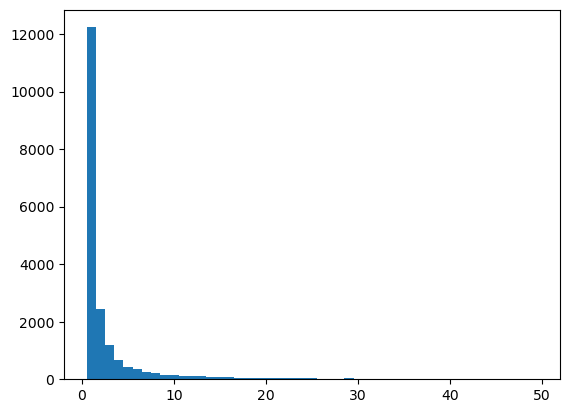

In [44]:
h = [ x for x,y in histo]
plt.hist(h, bins = np.arange(0.5, 50))

In [ ]:
sorted(list(index.keys()))

In [ ]:
len(index.keys())

Our system returns nothing. Can we write a fast suggestion utility that can quickly identify typos.

## Did you mean? 
So now we are going to write a utility that can identify mispelling and typos and suggest potential alternatives. So let's start off with a naive approach that simply finds the closest word in the index in terms of edit distance:

In [ ]:
#! conda install -y Distance

In [46]:
import distance

print( "Jaccard('a b', 'b c')=", distance.jaccard('a b', 'b c'))
print( "Levenshtein('a b', 'b c')=", distance.levenshtein('a b','b c') )

Jaccard('a b', 'b c')= 0.5
Levenshtein('a b', 'b c')= 2


In [48]:
def did_you_mean_naive(word, index):
    start = datetime.datetime.now()
    if word in index:
        return word
    else:
        distances = [(distance.levenshtein(word, iw), iw) for iw in index]
        distances.sort()
        print('did_you_mean_naive() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
        for i in range(10):
            print(distances[i][0], distances[i][1])
        return distances[0][1]
    
    

did_you_mean_naive('chopy', index)

did_you_mean_naive() elapsed time:  0.503461
1 choppy
1 copy
2 Ahoy
2 chips
2 chose
2 cop
2 copay
2 cozy
2 holy
2 hop


'choppy'

In [52]:
did_you_mean_naive('zxcvbnmasdf', index)

did_you_mean_naive() elapsed time:  0.87126
7 bnardu
7 command
7 commands
7 xmas
8 2xmost
8 AAdvantage
8 Advantage
8 AirCanada
8 Alabama
8 Arkansas


'bnardu'

In [54]:
word_index["hop"]

NameError: name 'word_index' is not defined

In [56]:
did_you_mean_naive('spel', index)

did_you_mean_naive() elapsed time:  0.380023
1 spec
1 spell
2 Aspen
2 Feel
2 Opal
2 Open
2 Tel
2 aspen
2 del
2 feel


'spec'

In [60]:
did_you_mean_naive('asdkendskd', index)

did_you_mean_naive() elapsed time:  0.787251
5 addressed
5 asked
5 astounded
5 astounds
5 attended
5 sends
5 spends
5 weekends
6 Asked
6 Islands


'addressed'

In [62]:
did_you_mean_naive("word", index)

'word'

In [64]:
did_you_mean_naive("virginamericAR", index)

did_you_mean_naive() elapsed time:  1.155553
2 virginamerica
3 virginAmerica
4 VirginAmerica
5 virginmedia
5 “VirginAmerica
5 😂VirginAmerica
6 latinamerican
7 Panamerican
7 onlyinAmerica
7 virginatlantic


'virginamerica'

In [ ]:
did_you_mean_naive('discont', index)

In [ ]:
did_you_mean_naive('arival', index)

In [ ]:
len(index.keys())

The suggestion utility runs much slower than the actual query!!! How do we fix this? We can use the same trick as before: a fast algorithm to find reasonable candidates and a slower algorithm to refine those candidates.

In fact, we will use an inverted index again. Just this time over sub-sequences of letters and not words. The first thing that we are going to do is to calculate n-grams these are contiguous sub-sequences of letters.

In [66]:
#ngram
#def find_ngrams(word, n):
#    return list(zip(*[word[i:] for i in range(n)]))

def find_ngrams(word, n):
    '''digest a word (a string) into a list of len(word)-n+1 
    ngrams of length n.'''
    return [word[i:i+n] for i in range(0, len(word)-n+1)]

find_ngrams('dave', 2)

['da', 'av', 've']

Next, we are going to build a "word" index, an indexing structure that maps ngrams to words that contain them.

In [68]:
def build_word_index(index, n):
    '''Builds a dictionary that maps ngrams contained in the 
    keys of index to the keys themselves.'''
    start = datetime.datetime.now()  
    word_index = {}
    for word in index:
        ngrams = find_ngrams(word, n)     
        for subseq in ngrams:       
            if subseq not in word_index:
                word_index[subseq] = set()       
            word_index[subseq].add(word) #add a pointer to the relevant word
    
    print('build_word_index() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
    return word_index

word_index = build_word_index(index, 3)
print(repr(word_index)[0:400])


build_word_index() elapsed time:  0.129202
{'Vir': {'Virgin', 'wantVirginAmerica', '“VirginAmericaYouve', 'Virtual', '“VirginAmerica', 'Virginia', 'WeRVirgin', '😂VirginAmerica', 'VirginAmerica', 'VirginAtlantic', 'Virgins'}, 'irg': {'infovirginamericacom', 'wantVirginAmerica', 'virginmedia', 'WeRVirgin', '😂VirginAmerica', 'plannedneverflyvirginforbusiness', 'SouthwestAirgive', 'Virgins', 'nomorevirgin', '“VirginAmerica', 'virgin✨😱✈️', 'vir


In [70]:
list(word_index.keys())[0:10]

['Vir', 'irg', 'rgi', 'gin', 'inA', 'nAm', 'Ame', 'mer', 'eri', 'ric']

In [ ]:
len(word_index.keys()) 

In [72]:
hist = { k: len(word_index[k]) for k in word_index.keys()}
hist

{'Vir': 11,
 'irg': 23,
 'rgi': 38,
 'gin': 94,
 'inA': 11,
 'nAm': 9,
 'Ame': 30,
 'mer': 165,
 'eri': 148,
 'ric': 105,
 'ica': 163,
 'Wha': 8,
 'hat': 76,
 'dhe': 3,
 'hep': 5,
 'epb': 1,
 'pbu': 1,
 'bur': 30,
 'urn': 34,
 'sai': 44,
 'aid': 17,
 'plu': 7,
 'lus': 15,
 'you': 71,
 'ouv': 4,
 'uve': 5,
 'add': 26,
 'dde': 15,
 'ded': 80,
 'com': 235,
 'omm': 63,
 'mme': 31,
 'erc': 29,
 'rci': 11,
 'cia': 56,
 'ial': 52,
 'als': 44,
 'the': 222,
 'exp': 57,
 'xpe': 39,
 'per': 120,
 'rie': 97,
 'ien': 87,
 'enc': 98,
 'nce': 167,
 'tac': 28,
 'ack': 112,
 'cky': 10,
 'did': 10,
 'idn': 12,
 'dnt': 16,
 'tod': 20,
 'oda': 28,
 'day': 97,
 'Mus': 3,
 'ust': 170,
 'mea': 19,
 'ean': 49,
 'nee': 26,
 'eed': 51,
 'tak': 20,
 'ake': 64,
 'ano': 13,
 'not': 88,
 'oth': 84,
 'her': 179,
 'tri': 70,
 'rip': 30,
 'its': 45,
 'rea': 178,
 'eal': 62,
 'all': 248,
 'lly': 115,
 'agg': 30,
 'ggr': 6,
 'gre': 41,
 'res': 233,
 'ess': 238,
 'ssi': 100,
 'siv': 21,
 'ive': 180,
 'bla': 18,
 'las': 6

We can use this word index to build a more sophisticated search:
* Only consider words that share a minimum number of ngrams with the lookup word

In [76]:
def did_you_mean_better(word, word_index, n, thresh=1):
    '''Finds the closest key in index to the query word, but only check
    for words that share at least one ngram with the query word.  Uses
    word_index.
    '''
    start = datetime.datetime.now()
    
    candidate_words = {}
    ngrams = find_ngrams(word, n)
    
    for ngram in ngrams:
        candidates = word_index.get(ngram, set())
        
        for candidate in candidates:
            candidate_words[candidate] = candidate_words.get(candidate,0) + 1
    
    
    
    distances = [(distance.levenshtein(word, iw), iw) for iw in candidate_words if candidate_words[iw] >= thresh]
    distances.sort()
        
    print('did_you_mean_better() elapsed time: ', (datetime.datetime.now()-start).total_seconds())
        
    return distances[0][1]
    

did_you_mean_better('chopys', word_index, 3)

did_you_mean_better() elapsed time:  0.002431


'choppy'

Notice how much faster this approach is!! 0.992237 secs v.s. 0.003581 seconds.

## Putting it all together

Now, let's write the full program and try out some queries

In [78]:
def find_final(phrase, \
               tweets, \
               index, \
               word_index, \
               n=3, \
               thresh=1):
    print('Searching for...' + phrase + " in " + str(len(tweets)) + " tweets")
    out = find_index(phrase, tweets, index)
    print('Found ' + str(len(out)) + ' matches')
    
    if len(out) == 0:
        for word in phrase.split():
            if word not in index:
                print('Did you mean: ' + did_you_mean_better(word, word_index, n, thresh) + ' instead of ' + word + '?')
    else:
        print(out)

find_final('choppy landing', tweets, index, word_index)

Searching for...choppy landing in 14640 tweets
Find() elapsed time:  3e-06
Found 1 matches
['@VirginAmerica pilot says we expect a choppy landing in NYC due to some gusty winds w/a temperature of about 5 degrees &amp; w/the windchill -8']


In [80]:
find_final('chopy landing', tweets, index, word_index)

Searching for...chopy landing in 14640 tweets
Found 0 matches
did_you_mean_better() elapsed time:  0.002159
Did you mean: choppy instead of chopy?


In [ ]:
find_final('choppy landig', tweets, index, word_index)

In [ ]:
find_final('LAX', tweets, index, word_index)

In [ ]:
find_final('LAXS', tweets, index, word_index)

In [82]:
26*26*26

17576